In [1]:
import torch, random, numpy as np, platform

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = (
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
print("Device:", device, "| torch:", torch.__version__, "| mac:", platform.machine())

Device: mps | torch: 2.9.0 | mac: arm64


In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "kevinmorgado/spanish-news-classification",
    "df_total.csv",
)

df = (
    df.rename(columns={"news": "text", "Type": "label"})[["text", "label"]]
    .dropna()
    .reset_index(drop=True)
)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])
NUM_LABELS = len(le.classes_)
print("Clases:", list(le.classes_), "| NUM_LABELS:", NUM_LABELS)

Clases: ['Alianzas', 'Innovacion', 'Macroeconomia', 'Otra', 'Regulaciones', 'Reputacion', 'Sostenibilidad'] | NUM_LABELS: 7


In [3]:
from datasets import Dataset
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-multilingual-cased"  # rápido y suficiente
MAX_LENGTH = 32
BATCH_SIZE = 32

hf = Dataset.from_pandas(df)
splits = hf.train_test_split(test_size=0.2, seed=SEED)
tmp = splits["test"].train_test_split(test_size=0.5, seed=SEED)
train_ds, val_ds, test_ds = splits["train"], tmp["train"], tmp["test"]

tok = AutoTokenizer.from_pretrained(MODEL_NAME)


def tokenize(batch):
    return tok(
        batch["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH
    )


train_ds = train_ds.map(tokenize, batched=True, remove_columns=["text"])
val_ds = val_ds.map(tokenize, batched=True, remove_columns=["text"])
test_ds = test_ds.map(tokenize, batched=True, remove_columns=["text"])

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/Users/cariuss/Desktop/TELLEZ-GUILLENT-PRACTICA-I /.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/973 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

In [4]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=NUM_LABELS
)

# Congela el encoder (entrenas solo la cabeza => mucho más rápido)
for p in model.base_model.parameters():
    p.requires_grad = False

model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [5]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

data_collator = DataCollatorWithPadding(tokenizer=tok, padding="longest")

args = TrainingArguments(
    output_dir="/tmp/bert-trash",            # ✅ carpeta temporal del sistema (se borra sola)
    overwrite_output_dir=True,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    evaluation_strategy="no",               # ✅ evita checkpoints de evaluación
    save_strategy="no",                     # ✅ no guarda checkpoints
    num_train_epochs=2,                     # prueba rápida
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_strategy="no",                  # ✅ no crea logs
    report_to="none",                       # ✅ no usa TensorBoard / WandB
    disable_tqdm=False,                     # mantiene barra de progreso visible
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


/Users/cariuss/Desktop/TELLEZ-GUILLENT-PRACTICA-I /.venv/lib/python3.12/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/62 [00:00<?, ?it/s]

/Users/cariuss/Desktop/TELLEZ-GUILLENT-PRACTICA-I /.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'train_runtime': 3.8295, 'train_samples_per_second': 508.155, 'train_steps_per_second': 16.19, 'train_loss': 1.9000188765987274, 'epoch': 2.0}


TrainOutput(global_step=62, training_loss=1.9000188765987274, metrics={'train_runtime': 3.8295, 'train_samples_per_second': 508.155, 'train_steps_per_second': 16.19, 'total_flos': 16112783976576.0, 'train_loss': 1.9000188765987274, 'epoch': 2.0})

In [6]:
metrics = trainer.evaluate(test_ds)
print({k: round(v, 4) for k, v in metrics.items() if isinstance(v, (int, float))})

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 1.8693, 'eval_accuracy': 0.3279, 'eval_recall': 0.3279, 'eval_f1': 0.1619, 'eval_runtime': 0.2465, 'eval_samples_per_second': 495.019, 'eval_steps_per_second': 16.23, 'epoch': 2.0}


/Users/cariuss/Desktop/TELLEZ-GUILLENT-PRACTICA-I /.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


  0%|          | 0/4 [00:00<?, ?it/s]

=== MÉTRICAS GLOBALES ===
Accuracy : 0.3279
Precision: 0.1075
Recall   : 0.3279
F1-score : 0.1619

=== REPORTE POR CLASE ===
                precision    recall  f1-score   support

      Alianzas       0.00      0.00      0.00        19
    Innovacion       0.00      0.00      0.00        16
 Macroeconomia       0.33      1.00      0.49        40
          Otra       0.00      0.00      0.00        11
  Regulaciones       0.00      0.00      0.00        16
    Reputacion       0.00      0.00      0.00         6
Sostenibilidad       0.00      0.00      0.00        14

      accuracy                           0.33       122
     macro avg       0.05      0.14      0.07       122
  weighted avg       0.11      0.33      0.16       122



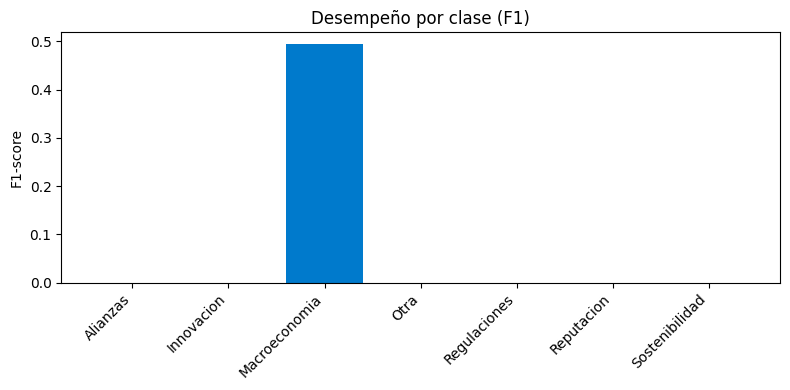

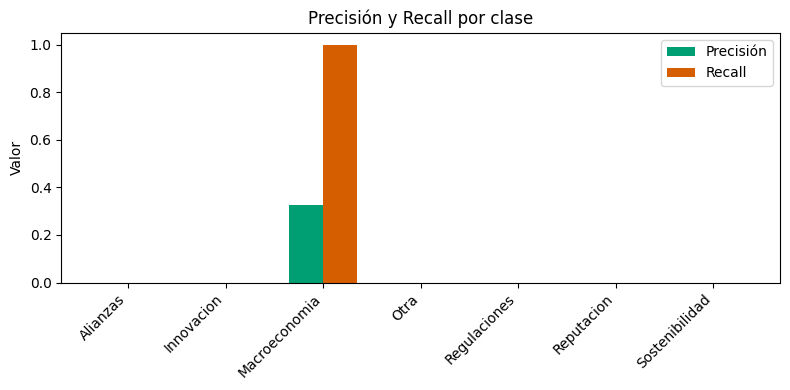

In [7]:
# ====================== 📊 RESULTADOS FINALES ======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# --- Predicciones sobre el conjunto de prueba ---
pred = trainer.predict(test_ds)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

# --- Métricas globales ---
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print("=== MÉTRICAS GLOBALES ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# --- Reporte por clase ---
class_names = list(le.classes_)
print("\n=== REPORTE POR CLASE ===")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


# --- F1 por clase ---
prec_c, rec_c, f1_c, sup_c = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)
plt.figure(figsize=(8, 4))
plt.bar(class_names, f1_c, color="#007acc")
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1-score")
plt.title("Desempeño por clase (F1)")
plt.tight_layout()
plt.show()

# --- Precisión y Recall por clase ---
x = np.arange(len(class_names))
width = 0.35
plt.figure(figsize=(8, 4))
plt.bar(x - width / 2, prec_c, width, label="Precisión", color="#009e73")
plt.bar(x + width / 2, rec_c, width, label="Recall", color="#d55e00")
plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylabel("Valor")
plt.title("Precisión y Recall por clase")
plt.legend()
plt.tight_layout()
plt.show()